## Simple CNN model for MNIST fashion categorization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import glob
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Kaggle API token to retrieve data
! pip install -q kaggle
from google.colab import files
if os.path.isfile('./kaggle.json') == False:
    files.upload()
print('Kaggle credential uploaded')

Saving kaggle.json to kaggle.json
Kaggle credential uploaded


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download mais202fall2021 -p /content/data/
! cd /content/data/
! unzip -d /content/data/ /content/data/test_images.npy
! unzip -d /content/data/ /content/data/train_images.npy

 53% 11.0M/20.7M [00:00<00:00, 114MB/s]
100% 20.7M/20.7M [00:00<00:00, 97.0MB/s]
 79% 41.0M/51.7M [00:00<00:00, 71.5MB/s]
100% 51.7M/51.7M [00:00<00:00, 105MB/s] 
  0% 0.00/165k [00:00<?, ?B/s]
100% 165k/165k [00:00<00:00, 54.3MB/s]
  0% 0.00/127 [00:00<?, ?B/s]
100% 127/127 [00:00<00:00, 127kB/s]
  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 60.4MB/s]
Archive:  /content/data/test_images.npy.zip
  inflating: /content/data/test_images.npy  
Archive:  /content/data/train_images.npy.zip
  inflating: /content/data/train_images.npy  


In [4]:
# show_image function 
import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap="Greys")
    plt.show()

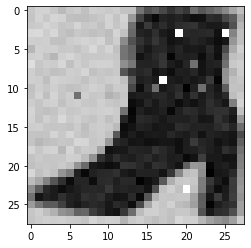

In [31]:
# load data and check dimensions
X_train = np.load('/content/data/train_images.npy')/255
X_test = np.load('/content/data/test_images.npy')/255
y_train = np.array(pd.read_csv('/content/data/train_labels.csv', index_col=0)).flatten()
show_image(X_test[0])
# print(y_test[0])
# print('Training dataset (X) shape: ',end = '')
# print(X_train.shape)
# print('Test dataset (X) shape: ',end = '')
# print(X_test.shape)
# print('Training dataset (y) shape: ',end = '')
# print(y_train.shape)
# print('Test dataset (y) shape: ',end = '')
# print(y_test.shape)

In [6]:
import skimage

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, SGD
from keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization, Flatten)
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import keras.backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [7]:
#Data preprocessing
t_count = 45000

X_val = X_train[t_count:]
X_train = X_train[:t_count]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# for i in range(len(X_train)):
#   X_train[i] = skimage.util.random_noise(X_train[i], mode='gaussian')

y_val = y_train[t_count:]
y_train = y_train[:t_count]
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

In [10]:
# training and evaluation parameters
def train_evaluate(model, X_train, y_train, X_val, y_val, 
                            num_epochs=11, batch_size=28):
    callbacks_list_default = [
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3),
        EarlyStopping(monitor='val_acc',patience=6)]

    history = model.fit(X_train, y_train, epochs=num_epochs,
                        batch_size = batch_size, validation_data = (X_val, y_val))

    print('Training data:', flush=True)
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    
    print('Validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Validation: loss %.3f - acc %.3f" % (loss, acc))

In [11]:
# ML model setup/parameters
def build_model():
    K.clear_session()
    lr=0.0001
    inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.12)(x)
    
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)    

    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.28)(x)            

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(units=NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=out)
    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = build_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                         

In [13]:
# training
train_evaluate(model, X_train, y_train, X_val, y_val, num_epochs=30, batch_size=32)

Epoch 1/30
1407/1407 [==============================] - 29s 12ms/step - loss: 1.4209 - accuracy: 0.4523 - val_loss: 0.8908 - val_accuracy: 0.6574
Epoch 2/30
1407/1407 [==============================] - 16s 11ms/step - loss: 0.9046 - accuracy: 0.6558 - val_loss: 0.7930 - val_accuracy: 0.6972
Epoch 3/30
1407/1407 [==============================] - 15s 11ms/step - loss: 0.8282 - accuracy: 0.6835 - val_loss: 0.7521 - val_accuracy: 0.7058
Epoch 4/30
1407/1407 [==============================] - 16s 11ms/step - loss: 0.7906 - accuracy: 0.6989 - val_loss: 0.7358 - val_accuracy: 0.7160
Epoch 5/30
1407/1407 [==============================] - 15s 11ms/step - loss: 0.7562 - accuracy: 0.7089 - val_loss: 0.6947 - val_accuracy: 0.7276
Epoch 6/30
1407/1407 [==============================] - 15s 11ms/step - loss: 0.7340 - accuracy: 0.7195 - val_loss: 0.6787 - val_accuracy: 0.7384
Epoch 7/30
1407/1407 [==============================] - 15s 11ms/step - loss: 0.7093 - accuracy: 0.7298 - val_loss: 0.6634 -

In [33]:
# prediction of slightly overfitted model
result = model.predict(X_test)
prediction = np.argmax(result, axis=1)